In [264]:
%matplotlib inline
import numpy as np
import pypico
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner

In [265]:
# Note i didn't upload the data file to github as it's too large
# comment my path and change to your own path to see data

# pico data on pypico's github
pico = pypico.load_pico("../data/jcset_py3.dat")


# CMB data
# FROM: http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt
df = pd.read_table('../data/COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows=1, names=['l', 'Dl', '-dDl', '+dDl'], delimiter='  ')
# make df with col0: x;     col1: y;    col2:y_err     
df['Dl_err'] = (df['+dDl'] + df['-dDl'])/2
df = df.drop(columns=['+dDl','-dDl'])


# sne data from lab 2
df_sne = pd.read_csv('../data/SCPUnion2.1_mu_vs_z.txt', names =['Event','z','dm','dm_err','prob'], header = None, skiprows=5, sep='\t')
df_sne = df_sne.drop(columns=['Event', 'prob'])

/var/folders/_2/d0xmq0nn39z8s3ccvbbr049h0000gn/T/ipykernel_28416/4169717628.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_table('../data/COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows=1, names=['l', 'Dl', '-dDl', '+dDl'], delimiter='  ')


In [266]:
# example parameters from pypico
As = 2.08e-9
ns = 0.97
tau = 0.055
ombh2 = 0.0225
omch2 = 0.117
H0 = 50
omk = -0.05
pivot_scalar = 0.05

theta = (As, ns, tau, ombh2, omch2, H0, omk)
labels=['As', 'ns', 'tau', 'ombh2', 'omch2', 'H0', 'omk']

note that
\begin{equation}
D_l = C_{l}\frac{l(l + 1)}{2\pi}
\end{equation}

In [267]:
def model_CMB(theta, pico=pico):
    '''
    generate data for power spectrum

    param:
        theta: parameters for the model
        pico: pico object as a modle generator
    return:
        dl_TT: result of Dl_model data
    '''
    #load our input dire
    As, ns, tau, ombh2, omch2, H0, omk = theta
    input_dir = {'As': As,
                'ns': ns,
                'tau': tau,
                'ombh2': ombh2,
                'omch2': omch2,
                'H0': H0,
                'omk': omk}

    result = pico.get(**input_dir, force=True)      # set True as we will use MCMC
    dl_TT = result['dl_TT']

    # TODO: the pico.outputs() gives ['cl_TT']; the result above gives ['dl_TT']
    # do i have to transfer as above?
    #cl_TT = [dl_TT[i]*2*np.pi/(i*(i+1)) for i in range(len(dl_TT))]

    return dl_TT


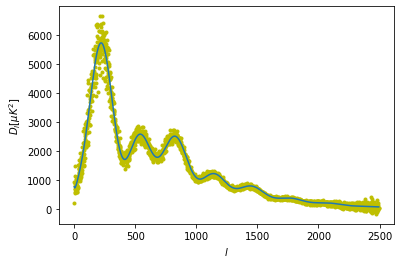

In [268]:
# just to see the example data to make sure we are on the right track
dl = model_CMB(theta)
dl = dl[2:]

plt.scatter(df['l'][:len(dl)], df['Dl'][:len(dl)], c='y', marker='.')
plt.plot(df['l'][:len(dl)], dl)
plt.xlabel("$l$")
plt.ylabel("$D_{l} [\mu K^2]$")
plt.show()


In [269]:
# helper function for MCMC posterior

def log_prior(theta):
    As, ns, tau, ombh2, omch2, H0, omk = theta
    if (1e-10 < As < 9e-9 and .3 < ns < 1.5 and -.4 < tau < .6 and 0 < ombh2 < .1 and -.1 < omch2 < .6 and -100 < H0 < 150 and -0.5 < omk < 0.7):
        return 0
    return -np.inf


def log_likeli(theta, df=df):
    #load data
    dmodel = model_CMB(theta)
    data = df.copy()

    # keep l of model and data the same
    dmodel = dmodel[2:]
    if len(dmodel) < len(data):
        data = data[:len(dmodel)]
    else:
        dmodel = dmodel[:len(data)]

    sigma2 = data['Dl_err']**2
    return -0.5 * np.sum((data['Dl']-dmodel)**2 / sigma2 + np.log(sigma2))


def log_post(theta, df=df):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likeli(theta, df=df)

In [270]:
def MCMC(theta, posterier=log_post, nwalkers=30, ndim=7, num_iter=4500):
    '''
    generate the sample data for the MCMC model

    param:
       theta: parameters for the model
       posterior: posterior function that take theta as input
       nwalkers: number of walkers
       ndim: dimension of theta
       num_iter: total iteration number
    return:
        sampler from the emcee package
    '''
    pos = 0.01*np.random.rand(nwalkers, ndim)+.995
    for i in range(ndim):
        pos[:, i] *= theta[i]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterier)
    sampler.run_mcmc(pos, num_iter, progress=True)
    
    return sampler

In [307]:
def plot_generator(sampler, df=df, labels=labels,  model=model_CMB, is_CMB=True, show_coner=True, show_trace=True, show_mult_sample=True, show_mean=True ):
    '''
    generate plots and show results

    param:
        sampler: sample data for the MCMC model
        df: dataFtrame contain our raw data
        labels: parameter names
        model: model we use that take theta as input
        is_CMB: if we want to genrate plots for cmb
        show_coner: if you want the coner plot
        show_trace: if you want the trace plot
        show_mult_sample: if you want the plot with different theta
        show_mean: if you want the mean theta plot
    return nothing
    '''
    samples = sampler.get_chain()
    flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

    err_bar = np.std(flat_samples, axis=0)
    mean_param = np.mean(np.mean(samples, axis=0), axis=0)
    print('mean parameters: ', mean_param)
    print('with err bars:', err_bar)

    dl = model(mean_param)
    # make the size of model and data the same
    dl = dl[2:]
    if len(df) > len(dl):
        df=df[:len(dl)]
    else:
        dl=dl[:len(df)]

    x = df.iloc[:, 0]
    y = df.iloc[:, 1]
    y_err = df.iloc[:, 2]


    def plot_corner():
        fig = corner.corner(flat_samples, bins=10, labels=labels,quantiles=[0.16, 0.5, 0.84])


    def plot_trace(ndim = len(labels)):
        f, axes = plt.subplots(ndim, figsize=(30, 30), sharex=True)
        samples = sampler.get_chain()
        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples[:, :, i], alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i])
        axes[-1].set_xlabel("Step number")


    def plot_multi_sample(size=100):
        inds = np.random.randint(len(flat_samples), size=size)

        plt.figure(figsize=(12, 5))
        plt.scatter(x, y, c='y', marker='.')
        for ind in inds:
            s = flat_samples[ind]
            dl_s = model(s)[2:]
            if len(dl_s)>len(df):
                dl_s = dl_s[:len(df)]
            plt.plot(x, dl_s, alpha=0.1, color='red')
        if not is_CMB:
            plt.xscale('log')
        else:
            plt.xlabel("$l$")
            plt.ylabel("$D_{l} [\mu K^2]$")
        plt.show()


    def plot_mean():
        plt.figure(figsize=(12, 5))
        plt.errorbar(x, y, yerr=y_err, fmt=".", alpha=0.3)
        plt.plot(x, dl)
        if not is_CMB:
            plt.xscale('log')
        else:
            plt.xlabel("$l$")
            plt.ylabel("$D_{l} [\mu K^2]$")
        plt.show()
        

    if show_coner:
        plot_corner()
    if show_trace:
        plot_trace()
    if show_mult_sample:
        plot_multi_sample()
    if show_mean:
        plot_mean()
    
    return dl


## full L

In [272]:
# full L
theta = (As, ns, tau, ombh2, omch2, H0, omk)
sampler = MCMC(theta, posterier=log_post)

100%|██████████| 4500/4500 [02:58<00:00, 25.18it/s]


mean parameters:  [ 1.90071061e-09  9.70377755e-01  7.76809557e-03  2.23503582e-02
  1.16727985e-01  4.93284819e+01 -7.18146847e-02]
with err bars: [1.69704024e-10 6.20442424e-03 4.68913683e-02 2.29611666e-04
 2.56609090e-03 5.13438546e+00 3.24092915e-02]


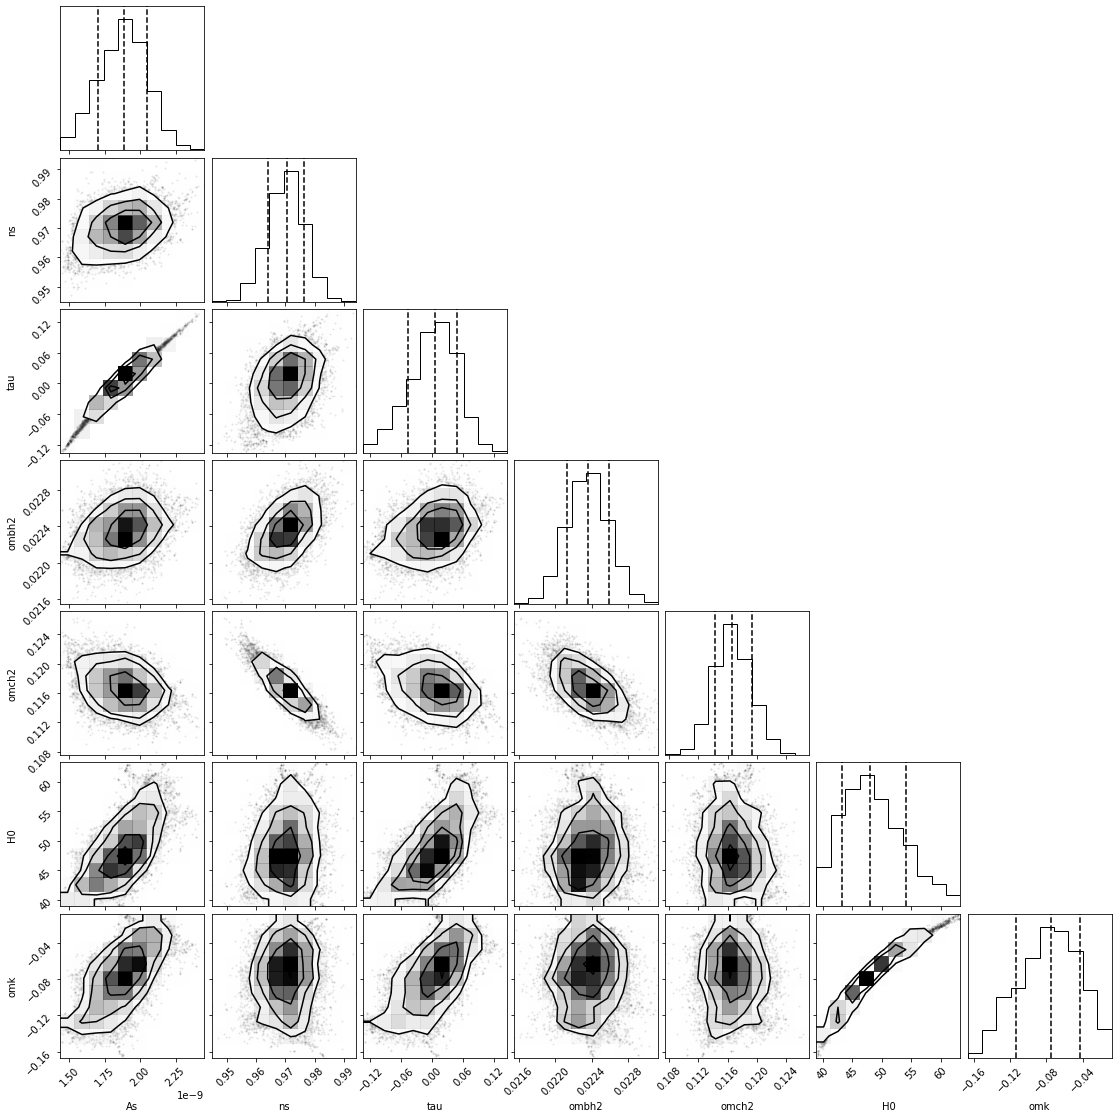

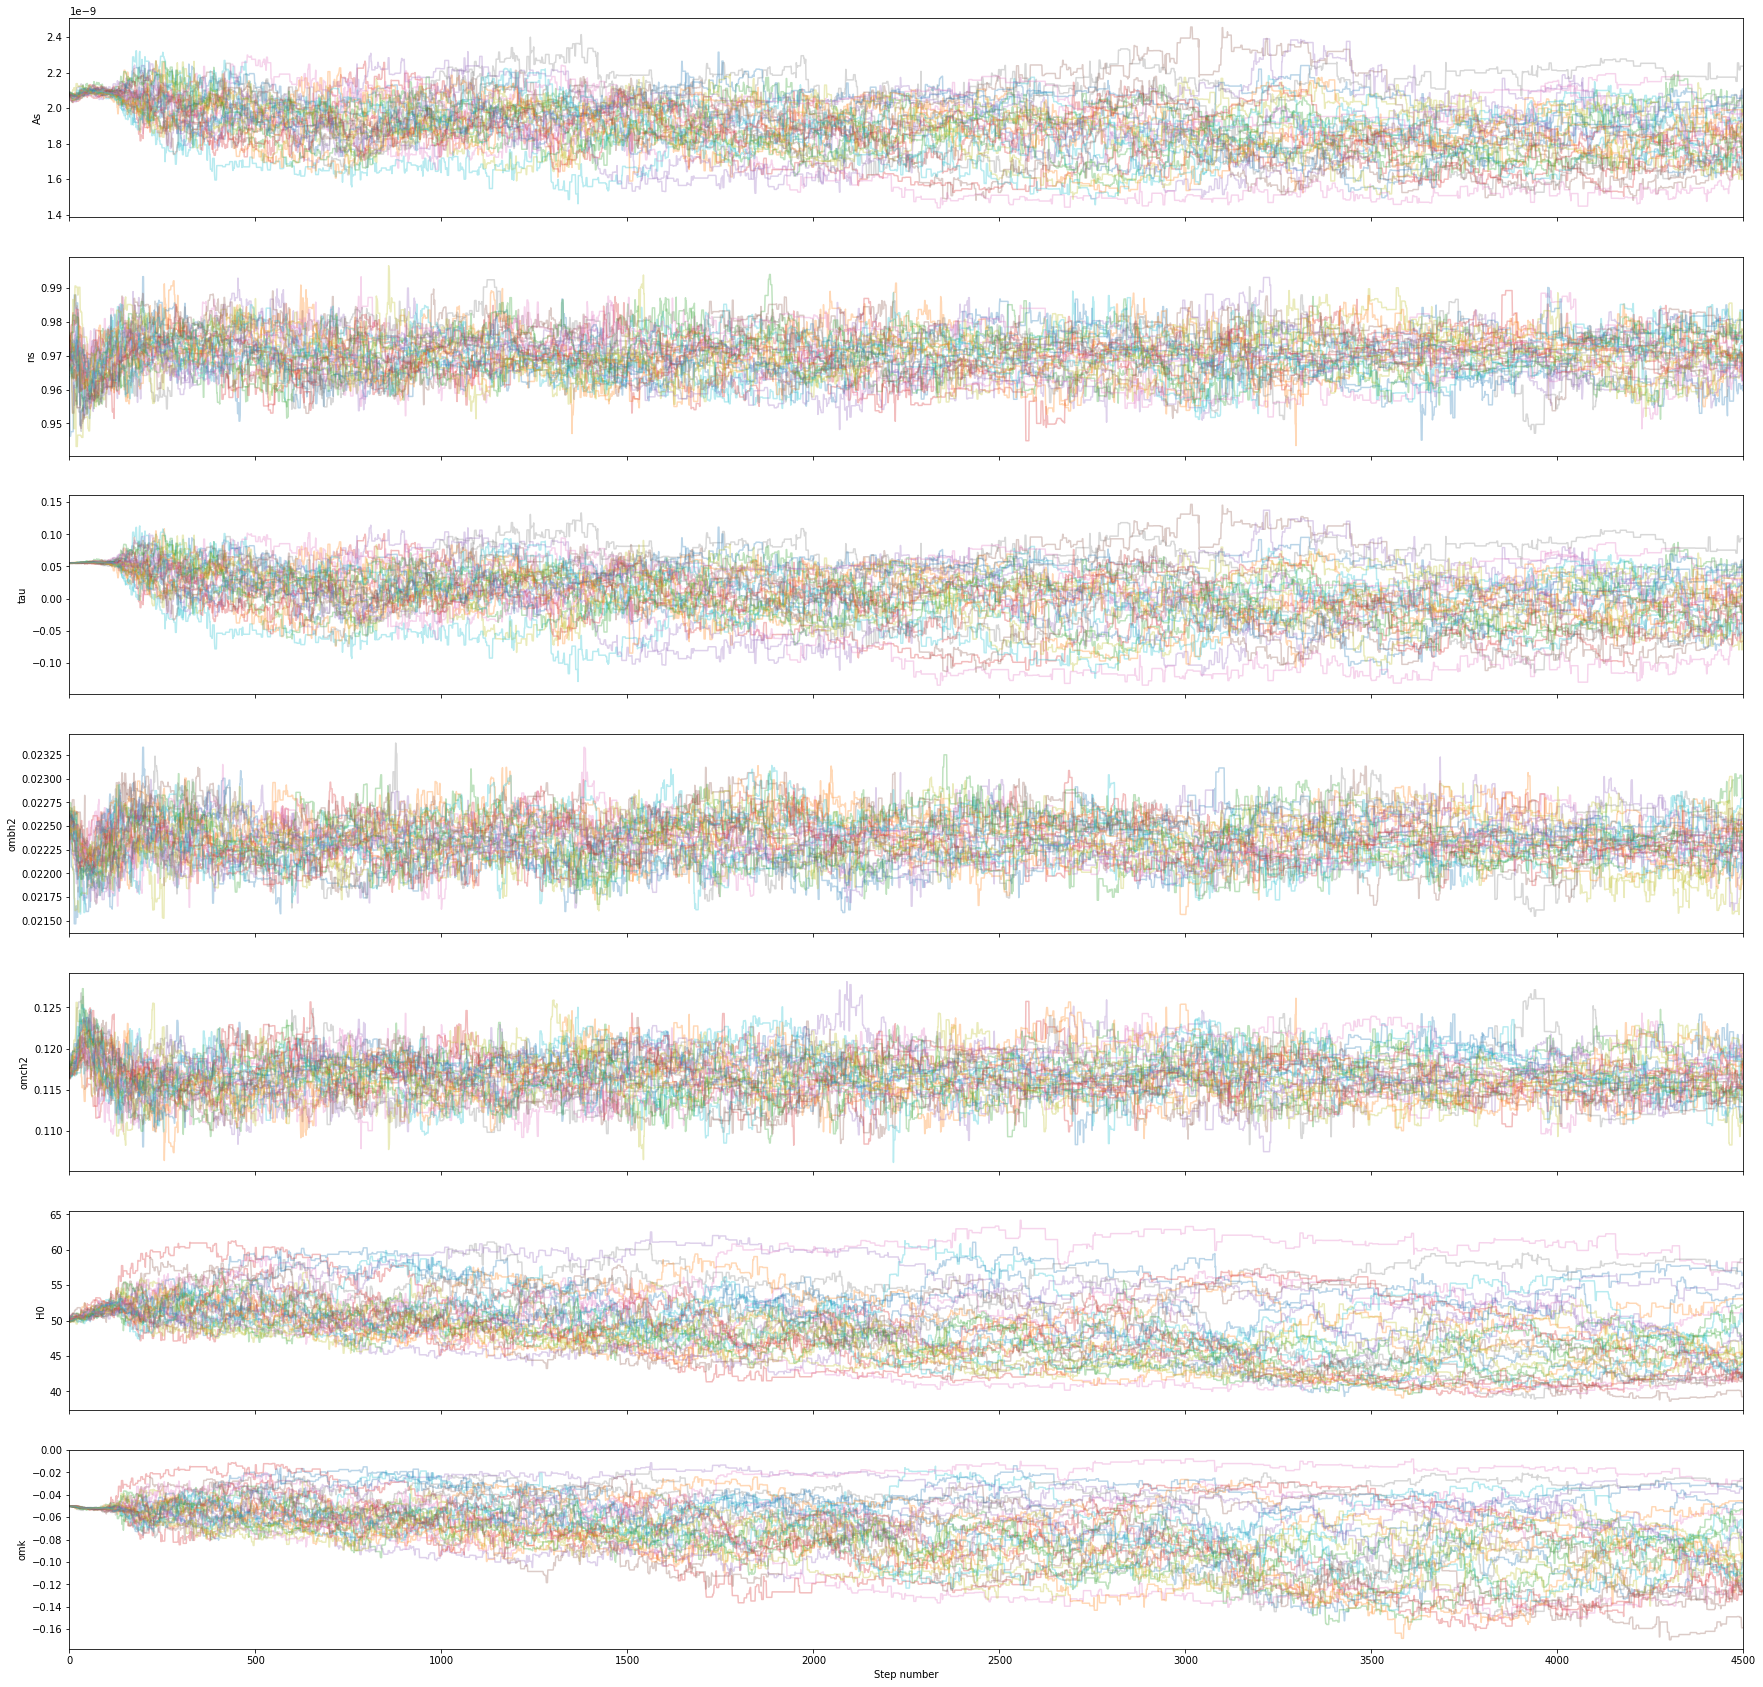

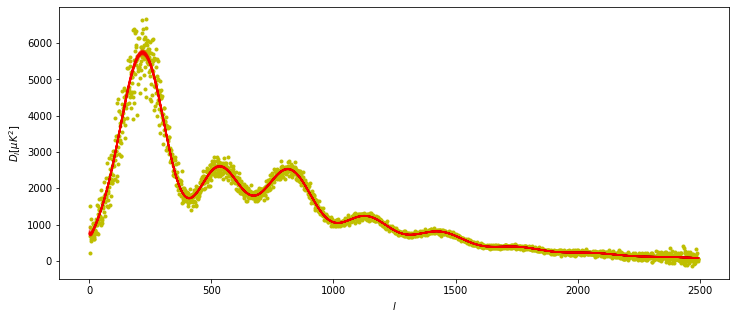

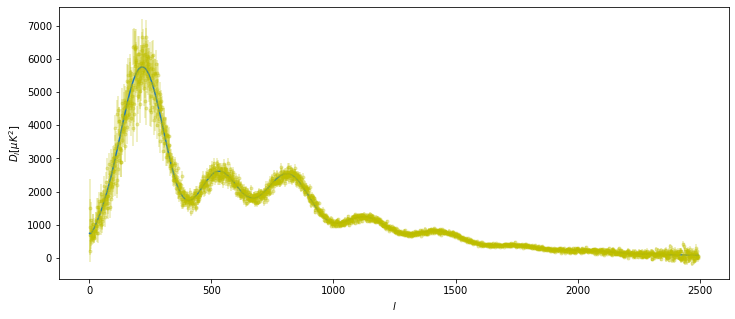

In [273]:
plot_generator(sampler, df=df)

## half L

In [275]:
# half L
df_half = df.copy()[:(len(df)+1)//2]
log_post_half = lambda t: log_post(t, df_half)

sampler_half = MCMC(theta, posterier=log_post_half)


100%|██████████| 4500/4500 [02:43<00:00, 27.49it/s]


mean parameters:  [ 1.87200007e-09  9.78111651e-01  1.79520752e-03  2.27118410e-02
  1.14269634e-01  4.98242951e+01 -7.18646058e-02]
with err bars: [2.19348541e-10 9.72484221e-03 6.11150130e-02 3.95587731e-04
 3.15374808e-03 5.21383428e+00 3.42822287e-02]


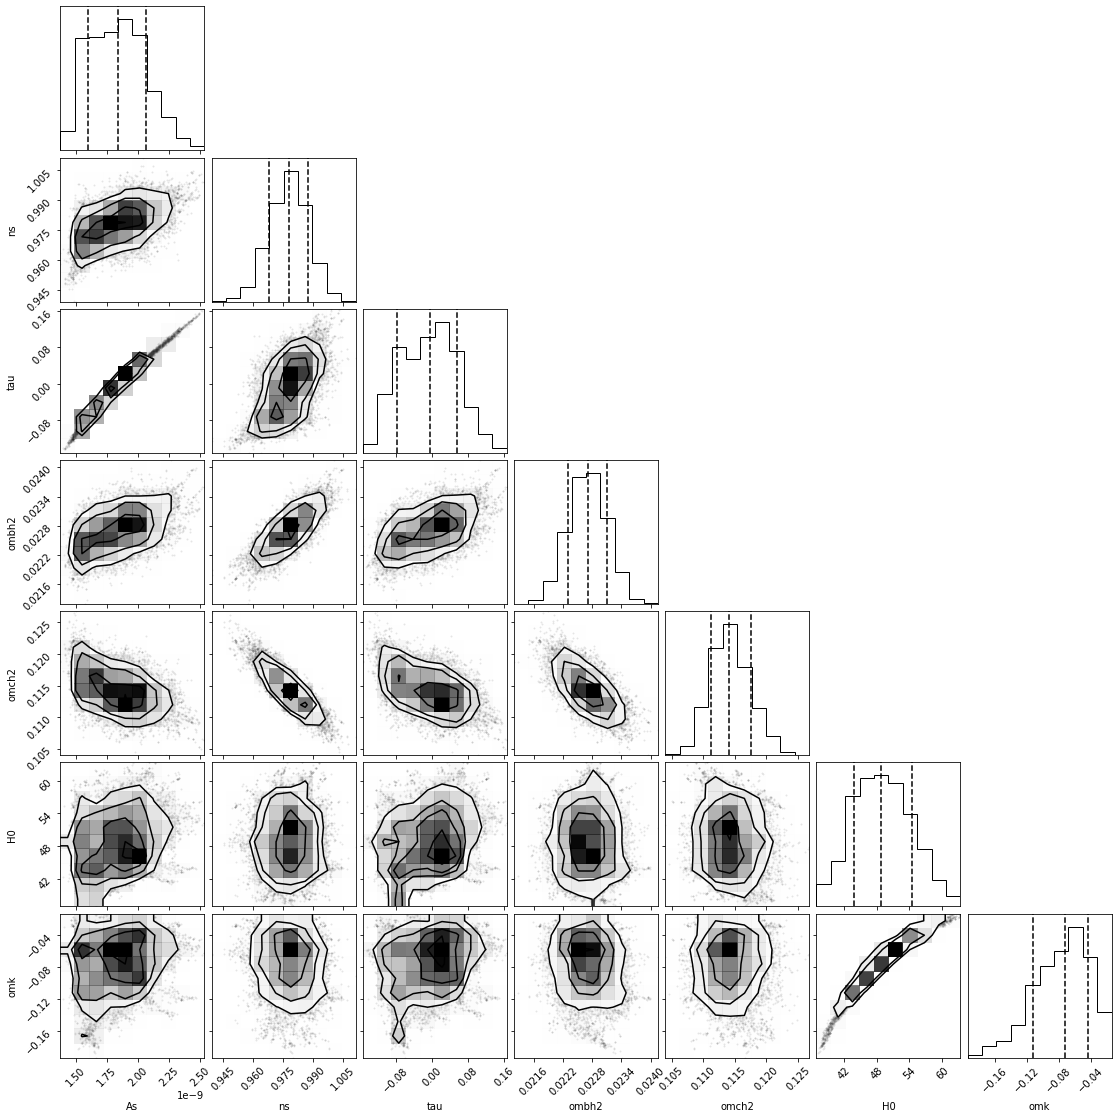

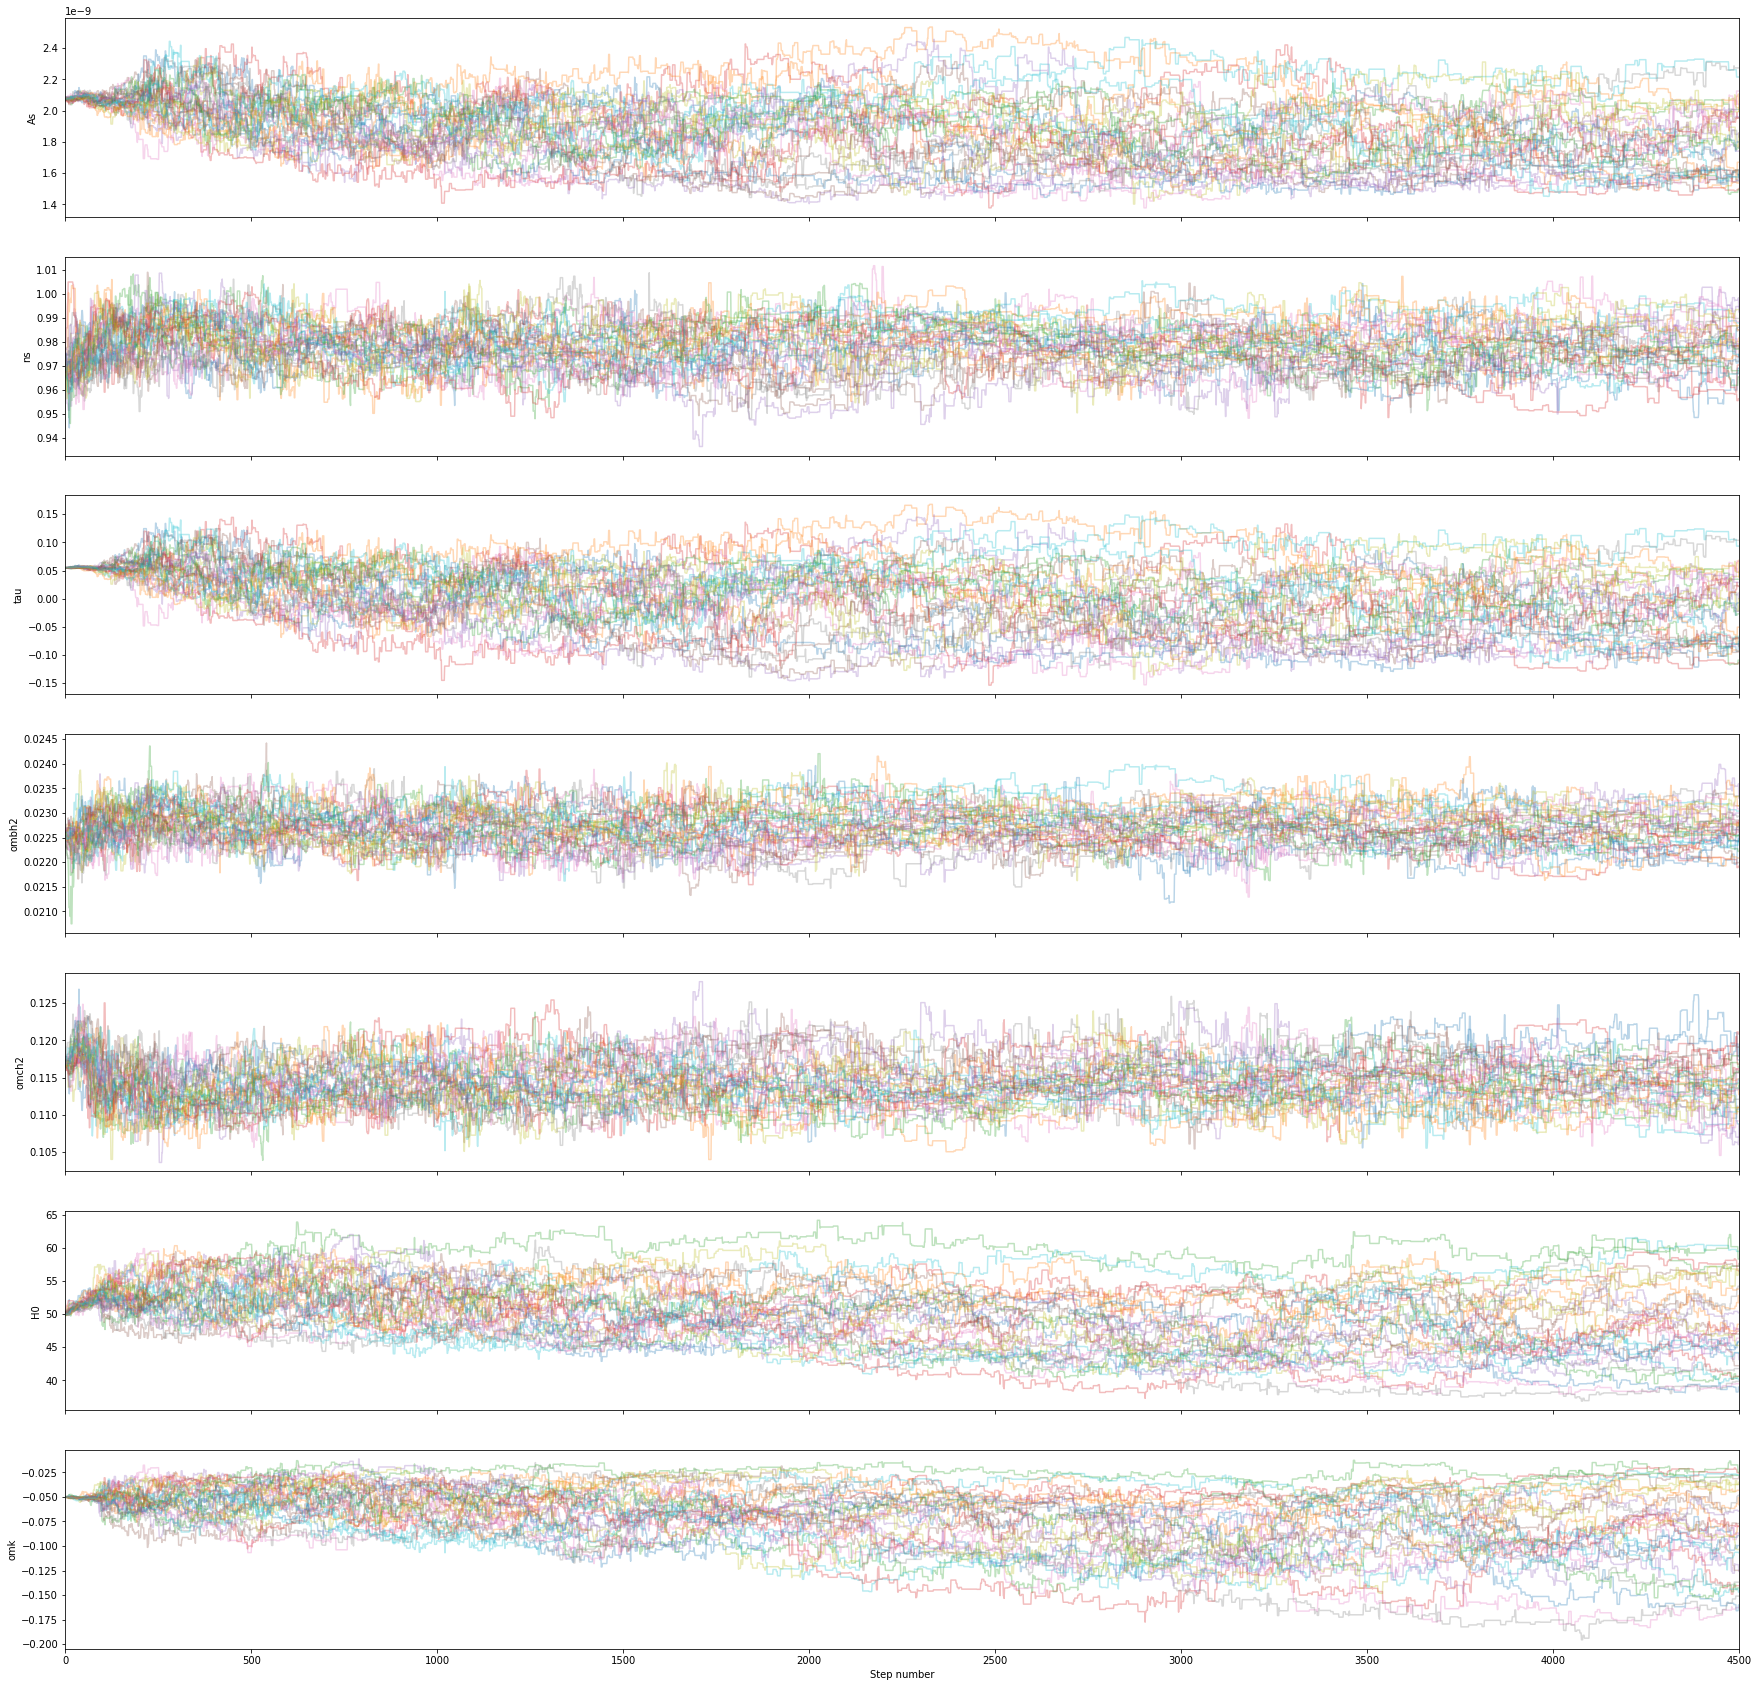

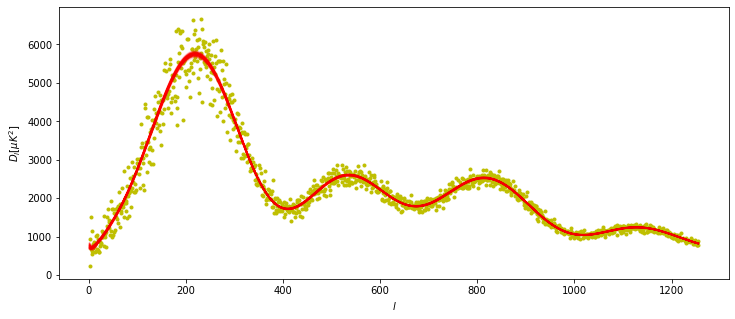

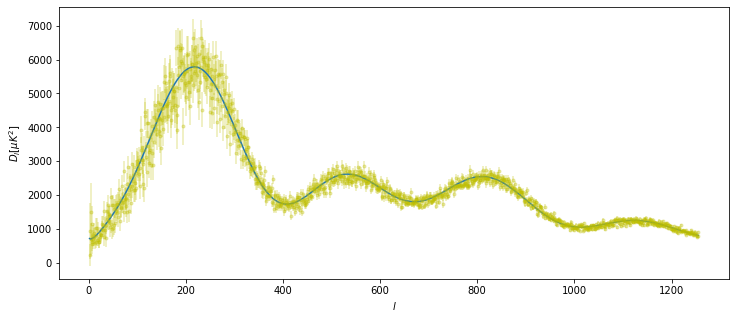

In [276]:
plot_generator(sampler_half, df=df_half)

## SNe data


In [277]:
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

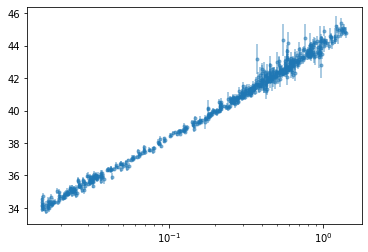

z         dm    dm_err
0  0.028488  35.346583  0.223906
1  0.050043  36.682368  0.166829
2  0.052926  36.817691  0.155756
3  0.070086  37.446737  0.158467
4  0.062668  37.483409  0.156099

In [278]:
# just plot the example data to make sure we are on the right track
plt.errorbar(df_sne['z'], df_sne['dm'], yerr=df_sne['dm_err'],fmt='.', alpha=0.5)
plt.xscale('log')
plt.show()

df_sne[:5]

In [306]:
def model_sne(theta, df=df_sne):
    '''
    generate data for power spectrum

    param:
        theta: parameters for the model
    return:
        model data
    '''
    H0, Om0, Ode0 = theta
    model = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0).distmod(df['z']).value
    return np.sort(model)

In [280]:
# helper function for MCMC posterior
def log_prior_sne(theta):
    H0, Om0, Ode0 = theta
    if 60. < H0 < 80. and 0.0 < Om0 < 0.6 and 0.1 < Ode0 < 1.2:
        return 0.0
    return -np.inf

def log_likeli_sne(theta, df=df_sne):
    model = model_sne(theta, df=df)
    sigma2 = df['dm_err'] ** 2
    return -0.5 * np.sum((df['dm'] - model) ** 2 / sigma2 + np.log(sigma2)) 

def log_post_sne(theta, df=df_sne):
    lp = log_prior_sne(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_likeli_sne(theta, df)

In [283]:
# initial guess
H0 = 70
om0 = 0.3
ode0 = 0.7
theta = (H0, om0, ode0)
labels=['H0', 'Om0', 'Ode0']

sampler_sne = MCMC(theta, posterier=log_post_sne, ndim=3, num_iter=3500)

100%|██████████| 3500/3500 [02:26<00:00, 23.82it/s]


mean parameters:  [69.98663664  0.27661444  0.71801029]
with err bars: [0.44955836 0.06880397 0.1176476 ]


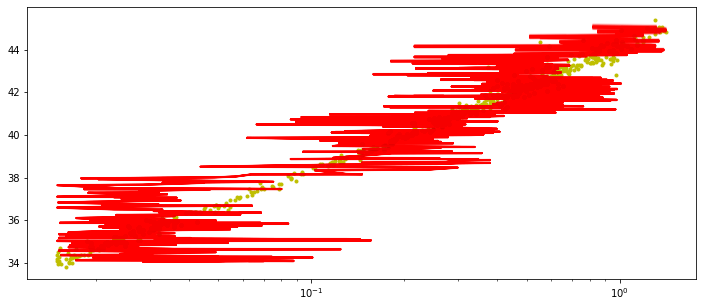

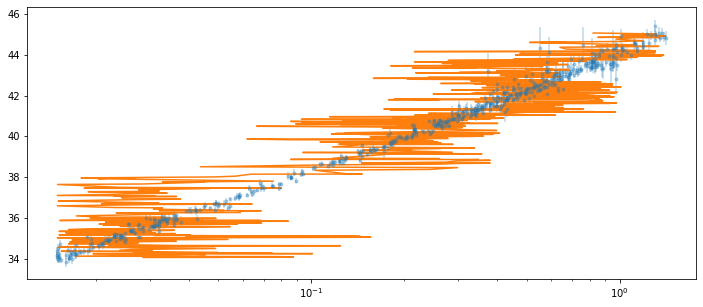

In [308]:
plot_generator(sampler_sne, df=df_sne, labels=labels, model=model_sne, is_CMB=False, show_coner=False, show_trace=False)

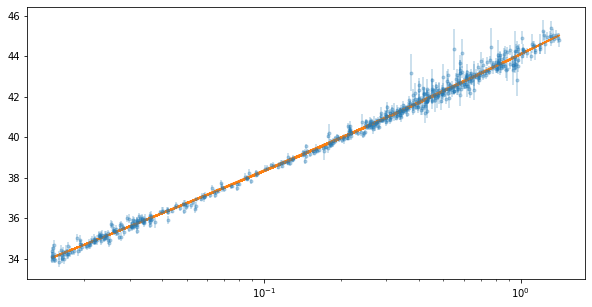

In [302]:

model = LambdaCDM(H0=70, Om0=.3, Ode0=.7).distmod(df_sne['z']).value
plt.figure(figsize=(10, 5))
plt.errorbar(df_sne['z'], df_sne['dm'], yerr=df_sne['dm_err'],fmt='.', alpha=0.3)

plt.plot(df_sne['z'], model)
plt.xscale('log')
plt.show()